<a href="https://colab.research.google.com/github/gnganesh99/spm_deconvolution/blob/main/Modeltraining_Tip_Deconvolution_ResNetmodule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code and Analysis by Ganesh Narasimha

Intial spm simulation by Richard Liu




# Import packages

In [1]:
# !pip install botorch
# !pip install gpytorch
!pip install spmsimu -q

In [2]:
# Simulator related packages

import numpy as np
import scipy as sp
# from numba import jit, njit, prange
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random

# from spmsimu.simulator import *
from spmsimu.simulator import *


In [3]:
#Download training data


#https://drive.google.com/file/d/1tS1MD5qP-xzpAMpmZ9yZLsSL2-doIrt7/view?usp=sharing
https://drive.google.com/file/d/1WyHNJj4TgIGYFlDNZb5uebmKt3il8Rz2/view?usp=sharing

!gdown https://drive.google.com/uc?id=1tS1MD5qP-xzpAMpmZ9yZLsSL2-doIrt7


Downloading...
From (original): https://drive.google.com/uc?id=1tS1MD5qP-xzpAMpmZ9yZLsSL2-doIrt7
From (redirected): https://drive.google.com/uc?id=1tS1MD5qP-xzpAMpmZ9yZLsSL2-doIrt7&confirm=t&uuid=8ffcab6f-fc13-428b-8f45-cef76b85cc25
To: /content/conv_alltips_training_data_1.h5
100% 755M/755M [00:08<00:00, 86.5MB/s]


In [4]:
import h5py

file_name = 'conv_alltips_training_data_1.h5'
hf = h5py.File(file_name, 'r+')


gt_images = np.asarray(hf['gt_images'])
conv_images = np.asarray(hf['conv_images'])
hf.close()

gt_images.shape, conv_images.shape

((720, 256, 256), (720, 256, 256))

# ResNetModule

Here we use a resnet module - this uses 3 resnets in the intial layer followed by another resnet in the next layer
This is based on the work by: https://onlinelibrary.wiley.com/doi/full/10.1002/advs.202203957


In [5]:
# ResNetModule

import torch
import torch.nn as nn

class ResNetBlock(nn.Module):

    """
    Basic Residual block for ResNet architecture

    """

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer (if needed for skip connection)
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Save the input for the skip connection

        # Pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply the downsample layer if dimensions differ
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the skip connection
        out += identity
        out = self.relu(out)

        return out



class ResNetWithUpsampling(nn.Module):
    """
    Double ResNets architecture with upsampling block
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        # First ResNet block (stride=1)
        self.res_block1 = ResNetBlock(in_channels, mid_channels, stride=1)

        # MaxPool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second ResNet block (stride=2)
        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block2 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)

        # Upsample layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1x1 convolution to match target dimensions
        self.final_conv = nn.Conv2d(out_channels + mid_channels, 1, kernel_size=1)

    def forward(self, x):
        # Pass through first ResNet block
        out1 = self.res_block1(x)  # Shape: [batch_size, mid_channels, 256, 256]

        # Downsample with MaxPool
        out1 = self.maxpool(out1)  # Shape: [batch_size, mid_channels, 128, 128]

        # Upsample after MaxPool
        out1_upsampled = self.upsample(out1)  # Shape: [batch_size, mid_channels, 256, 256]

        # Pass through second ResNet block
        out2 = self.res_block2(out1)  # Shape: [batch_size, out_channels, 64, 64]

        # Upsample the output of the second ResNet block
        out2_upsampled = self.upsample(out2)  # Shape: [batch_size, out_channels, 128, 128]
        out2_upsampled = self.upsample(out2_upsampled)  # Shape: [batch_size, out_channels, 256, 256]

        # Concatenate outputs along the channel dimension
        out = torch.cat([out1_upsampled, out2_upsampled], dim=1)  # Shape: [batch_size, mid_channels + out_channels, 256, 256]

        # Final 1x1 convolution to reduce to single channel
        out = self.final_conv(out)  # Shape: [batch_size, 1, 256, 256]

        return out





class ResNetModule(nn.Module):


    def __init__(self, input_channels: int, output_channels: int, res_depth: int):
        super().__init__()
        res_module = []

        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels

            res_module.append(ResNetBlock(input_channels, output_channels))

        self.res_module = nn.Sequential(*res_module)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines a forward pass
        """
        x = self.res_module(x)

        return x

class ResNetModuleWithUpsampling(nn.Module):
    """
    Double ResNet module architecture with upsampling block
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        # First ResNet block (stride=1)
        self.res_block1 = ResNetModule(in_channels, mid_channels, res_depth=5)

        # MaxPool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second ResNet block (stride=2)
        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block2 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)

        # Upsample layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1x1 convolution to match target dimensions
        self.final_conv = nn.Conv2d(out_channels + mid_channels, 1, kernel_size=1)

    def forward(self, x):
        # Pass through first ResNet block
        out1 = self.res_block1(x)  # Shape: [batch_size, mid_channels, 256, 256]

        # Downsample with MaxPool
        out1 = self.maxpool(out1)  # Shape: [batch_size, mid_channels, 128, 128]

        # Upsample after MaxPool
        out1_upsampled = self.upsample(out1)  # Shape: [batch_size, mid_channels, 256, 256]

        # Pass through second ResNet block
        out2 = self.res_block2(out1)  # Shape: [batch_size, out_channels, 64, 64]

        # Upsample the output of the second ResNet block
        out2_upsampled = self.upsample(out2)  # Shape: [batch_size, out_channels, 128, 128]
        out2_upsampled = self.upsample(out2_upsampled)  # Shape: [batch_size, out_channels, 256, 256]

        # Concatenate outputs along the channel dimension
        out = torch.cat([out1_upsampled, out2_upsampled], dim=1)  # Shape: [batch_size, mid_channels + out_channels, 256, 256]

        # Final 1x1 convolution to reduce to single channel
        out = self.final_conv(out)  # Shape: [batch_size, 1, 256, 256]

        return out


class ResNetModuleWithUpsampling_1(nn.Module):
    """
    Double ResNet module architecture with upsampling block
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        # First ResNet block (stride=1)
        self.res_block1 = ResNetModule(in_channels, mid_channels, res_depth=3)

        self.res_block2 = ResNetModule(mid_channels, mid_channels, res_depth=5)

        # MaxPool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second ResNet block (stride=2)
        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block3 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)

        # Upsample layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1x1 convolution to match target dimensions
        self.final_conv = nn.Conv2d(out_channels + mid_channels, 1, kernel_size=1)

    def forward(self, x):
        # Pass through first ResNet block
        out1 = self.res_block1(x)  # Shape: [batch_size, mid_channels, 256, 256]

        # Downsample with MaxPool
        out1 = self.maxpool(out1)  # Shape: [batch_size, mid_channels, 128, 128]


        out2 = self.res_block2(out1) # Shape = [batch_size, mid_channels, 128, 128]

        # Downsample with MaxPool
        out2 = self.maxpool(out2)  # Shape: [batch_size, mid_channels, 64, 64]

        # Upsample after MaxPool
        out2_upsampled = self.upsample(out2)  # Shape: [batch_size, mid_channels, 128, 128]
        out2_upsampled = self.upsample(out2_upsampled)  # Shape: [batch_size, mid_channels, 256, 256]

        # Pass through second ResNet block
        out3 = self.res_block3(out2)  # Shape: [batch_size, out_channels, 32, 32]

        # Upsample the output of the second ResNet block
        out3_upsampled = self.upsample(out3)  # Shape: [batch_size, out_channels, 64, 64]
        out3_upsampled = self.upsample(out3_upsampled)  # Shape: [batch_size, out_channels, 128, 128]
        out3_upsampled = self.upsample(out3_upsampled)  # Shape: [batch_size, out_channels, 256, 256]


        # Concatenate outputs along the channel dimension
        out = torch.cat([out2_upsampled, out3_upsampled], dim=1)  # Shape: [batch_size, mid_channels + out_channels, 256, 256]

        # Final 1x1 convolution to reduce to single channel
        out = self.final_conv(out)  # Shape: [batch_size, 1, 256, 256]

        return out


class ResNetModuleWithUpsampling_2(nn.Module):
    """
    Double ResNet module architecture with upsampling block
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        # First ResNet block (stride=1)
        self.res_block1 = ResNetModule(in_channels, mid_channels, res_depth=3)

        self.res_block2 = ResNetModule(mid_channels, mid_channels, res_depth=5)

        self.res_block3 = ResNetModule(mid_channels, mid_channels, res_depth=7)

        # MaxPool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second ResNet block (stride=2)
        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block4 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)

        # Upsample layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1x1 convolution to match target dimensions
        self.final_conv = nn.Conv2d(out_channels + mid_channels, 1, kernel_size=1)

    def forward(self, x):
        # Pass through first ResNet block
        out1 = self.res_block1(x)  # Shape: [batch_size, mid_channels, 256, 256]

        # Downsample with MaxPool
        out1 = self.maxpool(out1)  # Shape: [batch_size, mid_channels, 128, 128]


        out2 = self.res_block2(out1) # Shape = [batch_size, mid_channels, 128, 128]

        # Downsample with MaxPool
        out2 = self.maxpool(out2)  # Shape: [batch_size, mid_channels, 64, 64]

        # Upsample after MaxPool
        out2_upsampled = self.upsample(out2)  # Shape: [batch_size, mid_channels, 128, 128]
        out2_upsampled = self.upsample(out2_upsampled)  # Shape: [batch_size, mid_channels, 256, 256]


        out3 = self.res_block3(out2) # Shape: [batch_size, mid_channels, 64, 64]
        out3 = self.maxpool(out3)  # Shape: [batch_size, mid_channels, 32, 32]


        out3_upsampled = self.upsample(out3) # Shape: [batch_size, mid_channels, 64, 64]
        out3_upsampled = self.upsample(out3_upsampled) # Shape: [batch_size, mid_channels, 128, 128]
        out3_upsampled = self.upsample(out3_upsampled) # Shape: [batch_size, mid_channels, 256, 256]


        # Pass through second ResNet block
        out4 = self.res_block4(out3)  # Shape: [batch_size, out_channels, 16, 16]

        # Upsample the output of the second ResNet block
        out4_upsampled = self.upsample(out4)  # Shape: [batch_size, out_channels, 32, 32]
        out4_upsampled = self.upsample(out4_upsampled)  # Shape: [batch_size, out_channels, 64, 64]
        out4_upsampled = self.upsample(out4_upsampled)  # Shape: [batch_size, out_channels, 128, 128]
        out4_upsampled = self.upsample(out4_upsampled)  # Shape: [batch_size, out_channels, 256, 256]



        # Concatenate outputs along the channel dimension
        out = torch.cat([out2_upsampled, out3_upsampled, out4_upsampled], dim=1)  # Shape: [batch_size, mid_channels + out_channels, 256, 256]

        # Final 1x1 convolution to reduce to single channel
        out = self.final_conv(out)  # Shape: [batch_size, 1, 256, 256]

        return out


In [6]:
import torch.nn.functional as F

class ResNetModuleWithUpsampling_3(nn.Module):
    """
    Double ResNet module architecture with upsampling block
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        # First ResNet block (stride=1)
        self.res_block1 = ResNetModule(in_channels, mid_channels, res_depth=3)

        self.res_block2 = ResNetModule(mid_channels, mid_channels, res_depth=5)

        self.res_block3 = ResNetModule(mid_channels, mid_channels, res_depth=7)

        # MaxPool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second ResNet block (stride=2)
        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block4 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)

        # Upsample layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1x1 convolution to match target dimensions
        self.final_conv = nn.Conv2d(out_channels + mid_channels, 1, kernel_size=1)

    def forward(self, x):
        # ResNet blocks
        out1 = self.res_block1(x)
        out1 = self.maxpool(out1)

        out2 = self.res_block2(out1)
        out2 = self.maxpool(out2)

        out3 = self.res_block3(out2)
        out3 = self.maxpool(out3)

        out4 = self.res_block4(out3)

        # Precise upsampling to target size
        out2_upsampled = F.interpolate(out2, size=(256, 256), mode='bilinear', align_corners=True)
        out3_upsampled = F.interpolate(out3, size=(256, 256), mode='bilinear', align_corners=True)
        out4_upsampled = F.interpolate(out4, size=(256, 256), mode='bilinear', align_corners=True)

        # Concatenate
        out = torch.cat([out3_upsampled, out4_upsampled], dim=1)

        # Final convolution
        out = self.final_conv(out)

        return out




In [7]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (Downsampling path)
        self.encoder1 = self.conv_block(1, 64)  # Input channels changed to 1
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling path)
        self.upconv4 = self.upconv(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.decoder1 = self.conv_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)  # Output channels changed to 1

    def conv_block(self, in_channels, out_channels):
        """Convolutional block with two Conv2d layers."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        """Upsampling block using transposed convolution."""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.MaxPool2d(2)(e1))
        e3 = self.encoder3(nn.MaxPool2d(2)(e2))
        e4 = self.encoder4(nn.MaxPool2d(2)(e3))

        # Bottleneck
        b = self.bottleneck(nn.MaxPool2d(2)(e4))

        # Decoder path with skip connections
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)  # Skip connection
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)  # Skip connection
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)  # Skip connection
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)  # Skip connection
        d1 = self.decoder1(d1)

        # Final output
        return self.final_conv(d1)

In [8]:
class ResNetModuleWithUpsampling_3(nn.Module):
    """
    Double ResNet module architecture with upsampling block
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        # First ResNet block (stride=1)
        self.res_block1 = ResNetModule(in_channels, mid_channels, res_depth=3)

        self.res_block2 = ResNetModule(mid_channels, mid_channels, res_depth=5)

        self.res_block3 = ResNetModule(mid_channels, mid_channels, res_depth=7)

        # MaxPool layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second ResNet block (stride=2)
        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block4 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)

        # Upsample layer
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final 1x1 convolution to match target dimensions
        self.final_conv = nn.Conv2d(out_channels + mid_channels, 1, kernel_size=1)

    def forward(self, x):
        # ResNet blocks
        out1 = self.res_block1(x)
        out1 = self.maxpool(out1)

        out2 = self.res_block2(out1)
        out2 = self.maxpool(out2)

        out3 = self.res_block3(out2)
        out3 = self.maxpool(out3)

        out4 = self.res_block4(out3)

        # Precise upsampling to target size
        out2_upsampled = F.interpolate(out2, size=(256, 256), mode='bilinear', align_corners=True)
        out3_upsampled = F.interpolate(out3, size=(256, 256), mode='bilinear', align_corners=True)
        out4_upsampled = F.interpolate(out4, size=(256, 256), mode='bilinear', align_corners=True)

        # Concatenate
        out = torch.cat([out3_upsampled, out4_upsampled], dim=1)



        # Final convolution
        out = self.final_conv(out)

        return out

## ResNet Encoder and Unet Decoder

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetModuleWithUpsampling_3_UNet(nn.Module):
    """
    ResNet-based architecture with U-Net style upsampling and skip connections
    """
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()

        # ResNet Encoder
        self.res_block1 = ResNetModule(in_channels, mid_channels, res_depth=3)
        self.res_block2 = ResNetModule(mid_channels, mid_channels, res_depth=5)
        self.res_block3 = ResNetModule(mid_channels, mid_channels, res_depth=7)

        downsample = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block4 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # U-Net Decoder
        self.up4 = self._upconv(out_channels, mid_channels)
        self.dec4 = self._conv_block(mid_channels + mid_channels, mid_channels)

        self.up3 = self._upconv(mid_channels, mid_channels)
        self.dec3 = self._conv_block(mid_channels + mid_channels, mid_channels)

        self.up2 = self._upconv(mid_channels, mid_channels)
        self.dec2 = self._conv_block(mid_channels + mid_channels, mid_channels)

        self.up1 = self._upconv(mid_channels, mid_channels)
        self.dec1 = self._conv_block(mid_channels + in_channels, mid_channels)

        # Final 1x1 convolution for output
        self.final_conv = nn.Conv2d(mid_channels, 1, kernel_size=1)

    def _upconv(self, in_channels, out_channels):
        """Upsampling block using transposed convolution"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def _conv_block(self, in_channels, out_channels):
        """Convolutional block with two 3x3 convolutions"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.res_block1(x)
        e1_pool = self.maxpool(e1)

        e2 = self.res_block2(e1_pool)
        e2_pool = self.maxpool(e2)

        e3 = self.res_block3(e2_pool)
        e3_pool = self.maxpool(e3)

        e4 = self.res_block4(e3_pool)

        # Decoder with skip connections
        d4 = self.up4(e4)
        d4 = F.interpolate(d4, size=e3.shape[2:], mode="bilinear", align_corners=False)
        d4 = torch.cat([d4, e3], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = F.interpolate(d3, size=e2.shape[2:], mode="bilinear", align_corners=False)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = F.interpolate(d2, size=e1.shape[2:], mode="bilinear", align_corners=False)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        d1 = torch.cat([d1, x], dim=1)  # Skip connection to input
        d1 = self.dec1(d1)

        # Final output
        out = self.final_conv(d1)
        return out

In [11]:
#torch.cuda.empty_cache()

# Training functions

In [13]:
from torch.utils.data import Dataset, DataLoader

class PairedImageDataset(Dataset):
    def __init__(self, gt_images, conv_images, transform=None):
        """
        Args:
            gt_images (list): List of ground truth images.
            conv_images (list): List of distorted images.
            transform (callable, optional): Optional transform to apply to both images.
        """
        self.gt_images = gt_images
        self.conv_images = conv_images
        self.transform = transform

        assert len(gt_images) == len(conv_images), "Mismatch in number of ground truth and distorted images."

    def __len__(self):
        return len(self.gt_images)

    def __getitem__(self, idx):
        # Get the ground truth and distorted images
        gt_image = self.gt_images[idx]
        conv_image = self.conv_images[idx]

        # Apply any transformations if provided
        if self.transform:
            gt_image = self.transform(gt_image)
            conv_image = self.transform(conv_image)

        return conv_image, gt_image


import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Transformation to convert NumPy array to PyTorch tensor
transform = transforms.Compose([
    transforms.ToPILImage(),           # Convert NumPy array to PIL Image
    transforms.Resize((128, 128)),     # Resize to a fixed size
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    transforms.ToTensor(),             # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])


# Create the dataset
dataset = PairedImageDataset(gt_images, conv_images, transform=transform)

# Create the DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [14]:
import matplotlib.pyplot as plt

def visualize_results(model, dataloader):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Get a batch of distorted and ground truth images
        for distorted, ground_truth in dataloader:
            distorted, ground_truth = distorted.to(device), ground_truth.to(device)

            # Forward pass: get model predictions
            outputs = model(distorted)

            # Visualize the first image in the batch
            plt.figure(figsize=(12, 4))

            # Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(distorted[0].cpu().numpy()[0], cmap='gray')
            plt.title("Input Image (Distorted)")

            # Ground Truth
            plt.subplot(1, 3, 2)
            plt.imshow(ground_truth[0].cpu().numpy()[0], cmap='gray')
            plt.title("Ground Truth")

            # Model Output
            plt.subplot(1, 3, 3)
            plt.imshow(outputs[0].cpu().numpy()[0], cmap='gray')
            plt.title("Model Output")

            plt.show()
            # break  # Show only one batch

# Training

In [15]:
gt_images = np.asarray(gt_images)
conv_images = np.asarray(conv_images)

gt_images.shape, conv_images.shape

((720, 256, 256), (720, 256, 256))

## Train the ResNetModules

In [16]:
# Create the dataset
dataset = PairedImageDataset(gt_images, conv_images, transform=transform)

# Create the DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=6)


Epoch [1/100], Loss: 0.7630
Epoch [2/100], Loss: 0.6328
Epoch [3/100], Loss: 0.6072
Epoch [4/100], Loss: 0.5500
Epoch [5/100], Loss: 0.5577
Epoch [6/100], Loss: 0.5206
Epoch [7/100], Loss: 0.5430
Epoch [8/100], Loss: 0.5313
Epoch [9/100], Loss: 0.5483
Epoch [10/100], Loss: 0.5263
Epoch [11/100], Loss: 0.4968
Epoch [12/100], Loss: 0.5518
Epoch [13/100], Loss: 0.5096
Epoch [14/100], Loss: 0.5258
Epoch [15/100], Loss: 0.4705
Epoch [16/100], Loss: 0.4818
Epoch [17/100], Loss: 0.4730
Epoch [18/100], Loss: 0.4504
Epoch [19/100], Loss: 0.4416
Epoch [20/100], Loss: 0.4478
Epoch [21/100], Loss: 0.4510
Epoch [22/100], Loss: 0.4274
Epoch [23/100], Loss: 0.4342
Epoch [24/100], Loss: 0.4148
Epoch [25/100], Loss: 0.4022
Epoch [26/100], Loss: 0.4152
Epoch [27/100], Loss: 0.4012
Epoch [28/100], Loss: 0.4024
Epoch [29/100], Loss: 0.3972
Epoch [30/100], Loss: 0.3930
Epoch [31/100], Loss: 0.3831
Epoch [32/100], Loss: 0.3859
Epoch [33/100], Loss: 0.3789
Epoch [34/100], Loss: 0.3776
Epoch [35/100], Loss: 0

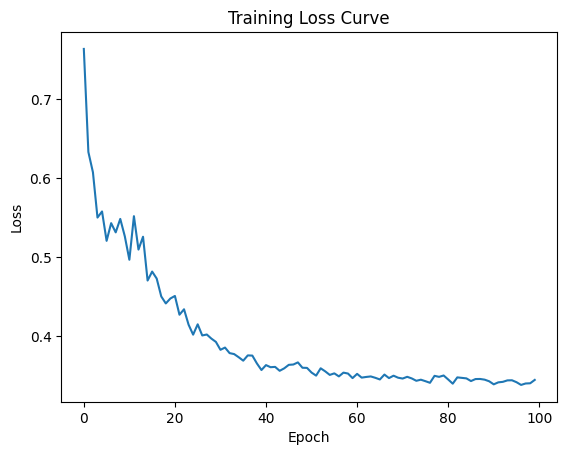

In [34]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ResNet model
model = ResNetModuleWithUpsampling_3_UNet(in_channels = 1, mid_channels = 64, out_channels = 128).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Or other appropriate loss, e.g., MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

import matplotlib.pyplot as plt

def train_model(model, dataloader, num_epochs, criterion, optimizer):
    model.train()
    loss_values = []  # Store loss values here
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for distorted, ground_truth in dataloader:
            distorted, ground_truth = distorted.to(device), ground_truth.to(device)

            # Forward pass
            outputs = model(distorted)
            loss = criterion(outputs, ground_truth)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Plot training loss curve
    plt.plot(loss_values)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()


# Assume DataLoader `train_loader` is already prepared
train_model(model, train_loader, num_epochs=100, criterion=criterion, optimizer=optimizer)


In [24]:
def deconvolution(model,img):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image = transform(img)  # Apply the transform to get the tensor
        image = image.to(device)
        output_image = model(image.unsqueeze(0))  # Add batch dimension (1, 1, H, W)
        output_image_np = output_image.cpu().numpy().squeeze(0)  # Remove batch dimension
        return output_image_np

In [25]:
torch.save(model, "resnet_encoder_unet_decoder_100epochs.pt")

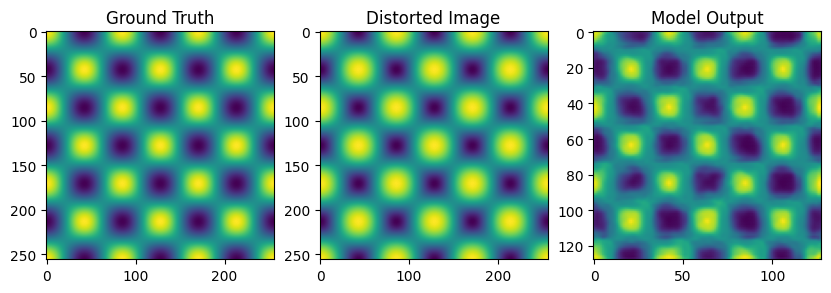

In [33]:
index = 102

image = transform(conv_images[index])  # Apply the transform to get the tensor

# Convert the output back to a numpy array for visualization
output_image_np = deconvolution(model, image)

# Display the deconvolved image
import matplotlib.pyplot as plt
fig, ax=plt.subplots(1,3,figsize=[10,3])
ax[0].imshow(gt_images[index])
ax[1].imshow(conv_images[index])
ax[2].imshow(output_image_np[0])  # Only show the single channel


ax[0].set_title("Ground Truth")
ax[1].set_title("Distorted Image")
ax[2].set_title("Model Output")
plt.show()

In [ ]:
visualize_results(model, train_loader)

# Dual ResNet Encoder - UNet Decoder
In Progress....

> Add blockquote



In [35]:

# Get data
!gdown https://drive.google.com/uc?id=1WyHNJj4TgIGYFlDNZb5uebmKt3il8Rz2


Downloading...
From (original): https://drive.google.com/uc?id=1WyHNJj4TgIGYFlDNZb5uebmKt3il8Rz2
From (redirected): https://drive.google.com/uc?id=1WyHNJj4TgIGYFlDNZb5uebmKt3il8Rz2&confirm=t&uuid=e02c8c13-2732-4cb7-a054-fe4b2a7cfb37
To: /content/training_data_2.h5
100% 1.07G/1.07G [00:12<00:00, 89.1MB/s]


In [36]:
import h5py

file_name = 'training_data_2.h5'
hf = h5py.File(file_name, 'r+')


gt_images = np.asarray(hf['gt_images'])
conv_images = np.asarray(hf['conv_images'])
psf_images = np.asarray(hf['tip_psf'])
hf.close()

gt_images.shape, conv_images.shape, psf_images.shape

((950, 256, 256), (950, 256, 256), (950, 100, 100))

Dual Resnet Encoder - UNet Decoder

In [47]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        A ResNet block with optional downsampling to align dimensions.
        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
            stride: Stride for the convolution.
            downsample: Downsampling layer to match the skip connection dimensions.
        """
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If downsample is not provided, add a default 1x1 convolution
        self.downsample = downsample or nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = self.downsample(x)  # Match dimensions of the skip connection

        # Residual path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Add the skip connection
        out += identity
        out = self.relu(out)

        return out

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Dual_ResNetEncoder_UNetDecoder(nn.Module):
    """
    Dual-input ResNet-based architecture with U-Net decoder and skip connections.
    """
    def __init__(self, in_channels_1, in_channels_2, mid_channels, out_channels):
        super().__init__()

        # ResNet Encoder 1 (full for input1)
        self.res_block1_enc1 = ResNetModule(in_channels_1, mid_channels, res_depth=3)
        self.res_block2_enc1 = ResNetModule(mid_channels, mid_channels, res_depth=5)
        self.res_block3_enc1 = ResNetModule(mid_channels, mid_channels, res_depth=7)

        downsample_enc1 = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block4_enc1 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample_enc1)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        # ResNet Encoder 2 (simplified for input2)
        self.res_block1_enc2 = ResNetModule(in_channels_2, mid_channels, res_depth=3)
        downsample_enc2 = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.res_block4_enc2 = ResNetBlock(mid_channels, out_channels, stride=2, downsample=downsample_enc2)
        self.upsample_enc2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Channel alignment for combining Encoder outputs
        self.channel_aligner = nn.Conv2d(out_channels, out_channels, kernel_size=1)

        # U-Net Decoder
        self.up4 = self._upconv(out_channels, mid_channels)
        self.dec4 = self._conv_block(mid_channels + mid_channels, mid_channels)

        self.up3 = self._upconv(mid_channels, mid_channels)
        self.dec3 = self._conv_block(mid_channels + mid_channels, mid_channels)

        self.up2 = self._upconv(mid_channels, mid_channels)
        self.dec2 = self._conv_block(mid_channels + mid_channels, mid_channels)

        self.up1 = self._upconv(mid_channels, mid_channels)
        self.dec1 = self._conv_block(mid_channels + mid_channels, mid_channels)

        # Final output layer
        self.final_conv = nn.Conv2d(mid_channels, 1, kernel_size=1)



    def _upconv(self, in_channels, out_channels):
        """Upsampling block using transposed convolution"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def _conv_block(self, in_channels, out_channels):
        """Convolutional block with two 3x3 convolutions"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, input1, input2):
        # Encoder 1 (Full ResNet for input1)
        e1_enc1 = self.res_block1_enc1(input1)
        e1_pool = self.avgpool(e1_enc1)

        e2_enc1 = self.res_block2_enc1(e1_pool)
        e2_pool = self.avgpool(e2_enc1)

        e3_enc1 = self.res_block3_enc1(e2_pool)
        e3_pool = self.avgpool(e3_enc1)

        e4_enc1 = self.res_block4_enc1(e3_pool)

        # Encoder 2 (res_block1 + avgpool + res_block4 + upsample)
        e1_enc2 = self.res_block1_enc2(input2)
        e1_enc2_pool = self.avgpool(e1_enc2)
        e4_enc2 = self.res_block4_enc2(e1_enc2_pool)
        e4_enc2_upsampled = self.upsample_enc2(e4_enc2)

        # Align spatial dimensions
        e4_enc2_upsampled = F.interpolate(
            e4_enc2_upsampled, size=e4_enc1.shape[2:], mode="bilinear", align_corners=False
        )

        # Align channels
        if e4_enc2_upsampled.shape[1] != e4_enc1.shape[1]:
            e4_enc2_upsampled = self.channel_aligner(e4_enc2_upsampled)

        # Combine outputs of Encoder 1 and Encoder 2
        e4_combined = e4_enc1 + e4_enc2_upsampled

        # Decoder with skip connections
        d4 = self.up4(e4_combined)
        d4 = F.interpolate(d4, size=e3_enc1.shape[2:], mode="bilinear", align_corners=False)
        d4 = torch.cat([d4, e3_enc1], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = F.interpolate(d3, size=e2_enc1.shape[2:], mode="bilinear", align_corners=False)
        d3 = torch.cat([d3, e2_enc1], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = F.interpolate(d2, size=e1_enc1.shape[2:], mode="bilinear", align_corners=False)
        d2 = torch.cat([d2, e1_enc1], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=input1.shape[2:], mode="bilinear", align_corners=False)
        d1 = self.dec1(d1)

        # Final output
        out = self.final_conv(d1)
        return out


In [68]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

class PairedImageDataset(Dataset):
    def __init__(self, gt_images, psf_images, conv_images, transform=None):
        """
        Args:
            gt_images (list): List of ground truth images (input 1).
            psf_images (list): List of PSF images (input 2).
            conv_images (list): List of convolution images (output).
            transform (callable, optional): Optional transform to apply to all images.
        """
        self.gt_images = gt_images
        self.psf_images = psf_images
        self.conv_images = conv_images
        self.transform = transform

        assert len(gt_images) == len(psf_images) == len(conv_images), \
            "Mismatch in number of ground truth, PSF, and convolution images."

    def __len__(self):
        return len(self.gt_images)

    def __getitem__(self, idx):
        # Retrieve images
        gt_image = self.gt_images[idx]    # Input 1
        psf_image = self.psf_images[idx]  # Input 2
        conv_image = self.conv_images[idx]  # Output

        # Apply transformations
        if self.transform:
            gt_image = self.transform(gt_image)
            psf_image = self.transform(psf_image)
            conv_image = self.transform(conv_image)

        return gt_image, psf_image, conv_image  # Return all three

# Transformation to apply to all images
transform = transforms.Compose([
    transforms.ToPILImage(),           # Convert NumPy array to PIL Image
    transforms.Resize((128, 128)),     # Resize to 128x128
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ToTensor(),             # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])


# Create the dataset
dataset = PairedImageDataset(gt_images, psf_images, conv_images, transform=transform)

# Create the DataLoader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)


In [69]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ResNet model
model = Dual_ResNetEncoder_UNetDecoder(in_channels_1 = 1, in_channels_2 = 1, mid_channels = 64, out_channels = 128).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Or other appropriate loss, e.g., MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

import matplotlib.pyplot as plt

def train_model(model, dataloader, num_epochs, criterion, optimizer):
    model.train()
    loss_values = []  # Store loss values here
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for distorted, psf_image, ground_truth in dataloader:
            distorted, psf_image, ground_truth = distorted.to(device),psf_image.to(device), ground_truth.to(device)

            # Forward pass
            outputs = model(distorted, psf_image)
            loss = criterion(outputs, ground_truth)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Plot training loss curve
    plt.plot(loss_values)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()


# Assume DataLoader `train_loader` is already prepared
train_model(model, train_loader, num_epochs=100, criterion=criterion, optimizer=optimizer)


RuntimeError: Given groups=1, weight of size [64, 128, 3, 3], expected input[16, 64, 128, 128] to have 128 channels, but got 64 channels instead

In [70]:
def deconvolution(model,img):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image = transform(img)  # Apply the transform to get the tensor
        image = image.to(device)
        output_image = model(image.unsqueeze(0))  # Add batch dimension (1, 1, H, W)
        output_image_np = output_image.cpu().numpy().squeeze(0)  # Remove batch dimension
        return output_image_np

In [ ]:
index = 102

image = transform(conv_images[index])  # Apply the transform to get the tensor

# Convert the output back to a numpy array for visualization
output_image_np = deconvolution(model, image)

# Display the deconvolved image
import matplotlib.pyplot as plt
fig, ax=plt.subplots(1,3,figsize=[10,3])
ax[0].imshow(gt_images[index])
ax[1].imshow(conv_images[index])
ax[2].imshow(output_image_np[0])  # Only show the single channel


ax[0].set_title("Ground Truth")
ax[1].set_title("Distorted Image")
ax[2].set_title("Model Output")
plt.show()